## Preamble

This notebook contains an example of how a deep learning network such as Keras can be used to develop a model in Python. The model can then be saved to disk and, using DeepLearning4J, run on Spark when scaling is required.

## Data Set Information:

The file "sonar.mines" contains 111 patterns obtained by bouncing sonar signals off a metal cylinder at various angles and under various conditions. The file "sonar.rocks" contains 97 patterns obtained from rocks under similar conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. The data set contains signals obtained from a variety of different aspect angles, spanning 90 degrees for the cylinder and 180 degrees for the rock. 

Each pattern is a set of 60 numbers in the range 0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time. The integration aperture for higher frequencies occur later in time, since these frequencies are transmitted later during the chirp. 

The label associated with each record contains the letter "R" if the object is a rock and "M" if it is a mine (metal cylinder). The numbers in the labels are in increasing order of aspect angle, but they do not encode the angle directly.



## Load Libraries

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import warnings
warnings.filterwarnings('ignore')

## Download the Data

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
df = pd.read_csv(url, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


### Example of a sonar pattern for a rock (R) and mine (M)

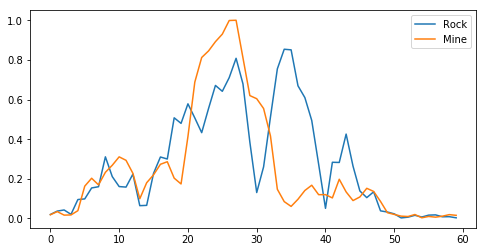

In [3]:
plt.figure(figsize=(8,4));
#plt.subplot(121);
plt.plot(df.iloc[0, 0:60], label='Rock');
plt.plot(df.iloc[203, 0:60], label='Mine');
plt.legend();

## Convert Text Labels to Integers

You will create a Keras Neural Network to classify each record as a Mine or a Rock. 

Although, It is straightforward to keep the labels "M" or "R" in Keras and have working code, the goal is to save the model and then load the model into DeepLearning4J, a java framework. The Java Code to import has been prebuilt and precompiled and expects numeric labels

In [4]:
df.iloc[:,-1].replace({'R':1, 'M':0}, inplace=True)

## Shuffle the Data

In [5]:
df = df.sample(frac=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
186,0.0209,0.0191,0.0411,0.0321,0.0698,0.1579,0.1438,0.1402,0.3048,0.3914,...,0.0078,0.0201,0.0104,0.0039,0.0031,0.0062,0.0087,0.0070,0.0042,0
134,0.1083,0.1070,0.0257,0.0837,0.0748,0.1125,0.3322,0.4590,0.5526,0.5966,...,0.0180,0.0110,0.0234,0.0276,0.0032,0.0084,0.0122,0.0082,0.0143,0
165,0.0221,0.0065,0.0164,0.0487,0.0519,0.0849,0.0812,0.1833,0.2228,0.1810,...,0.0089,0.0051,0.0015,0.0075,0.0058,0.0016,0.0070,0.0074,0.0038,0
72,0.0208,0.0186,0.0131,0.0211,0.0610,0.0613,0.0612,0.0506,0.0989,0.1093,...,0.0074,0.0063,0.0081,0.0087,0.0044,0.0028,0.0019,0.0049,0.0023,1
109,0.0264,0.0071,0.0342,0.0793,0.1043,0.0783,0.1417,0.1176,0.0453,0.0945,...,0.0214,0.0262,0.0177,0.0037,0.0068,0.0121,0.0077,0.0078,0.0066,0


## Build a (Simple) Neural Network

In [6]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [7]:
# split into input (X) and output (Y) variables
X = df.iloc[:,0:60]
Y = df.iloc[:,60]

In [8]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

# convert integers to dummy variables (hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=7764)

## Build a Model

In [10]:
model = Sequential()
model.add(Dense(100, input_dim=60, kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())
model.add(Dense(50, kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(rate=0.1))
model.add(BatchNormalization())
model.add(Dense(50, kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())
model.add(Dense(2, kernel_initializer='glorot_uniform', activation='sigmoid'))

## Compile the Model and Train

Modify the following cell and set your number of epochs and your batch size. 

In [11]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=40, batch_size=64)

Epoch 1/40
166/166 [==============================] - 2s 12ms/step - loss: 0.8987 - acc: 0.5000
Epoch 2/40
166/166 [==============================] - 0s 102us/step - loss: 0.8293 - acc: 0.5060
Epoch 3/40
166/166 [==============================] - 0s 132us/step - loss: 0.7785 - acc: 0.5271
Epoch 4/40
166/166 [==============================] - 0s 90us/step - loss: 0.7560 - acc: 0.5512
Epoch 5/40
166/166 [==============================] - 0s 114us/step - loss: 0.7166 - acc: 0.5753
Epoch 6/40
166/166 [==============================] - 0s 120us/step - loss: 0.6657 - acc: 0.6355
Epoch 7/40
166/166 [==============================] - 0s 127us/step - loss: 0.6588 - acc: 0.6416
Epoch 8/40
166/166 [==============================] - 0s 96us/step - loss: 0.6243 - acc: 0.6627
Epoch 9/40
166/166 [==============================] - 0s 108us/step - loss: 0.5948 - acc: 0.6988
Epoch 10/40
166/166 [==============================] - 0s 102us/step - loss: 0.5630 - acc: 0.7048
Epoch 11/40
166/166 [===========

In [12]:
model.evaluate(x=X_test, y=y_test, verbose=1)

42/42 [==============================] - 0s 6ms/step


[0.4784039258956909, 0.8571428514662243]

In [13]:
#model.predict(X_test)

## Save the Model

The model can be loaded into dl4j and run in a Spark context. A saved model includes the weights and the computation graph needed for either further training or inference. In this example we will load the model into dl4j and pass it our datafile and evaluate the accuracy of the model in dl4j running in spark. 

In [14]:
model.save('model/my_modelx.h5')

## Run Code in DL4J on Spark

DL4J has a KerasModelImport feature. Java code has been written and compiled that will import a keras model, run the model on a spark cluster.  
https://github.com/maxpumperla/dl4j_coursera/blob/master/src/main/java/skymind/dsx/KerasImportCSVSparkRunner.java

This Jar has the compiled class.  
https://github.com/maxpumperla/dl4j_coursera/releases/download/v0.4/dl4j-snapshot.jar
 
The class KerasImportCSVSparkRunner takes the following command line options, 

* indexLabel
    * Column in the data file containing Labels
    * Labels must be numeric
* train
    * Set to true or false
    * true: perform training using provided data file
    * false: perform evaluation using provided data file
* numClasses 
    * number of classes
* modelFileName
    * Saved h5 archive of your Keras Model
* dataFileName 
    * DataFile to run training/evaluation with

Set the next two code blocks to 'Code' instead of 'Raw' when running on a Spark cluster.